# Наивный Байес и спам
__Суммарное количество баллов: 10__


In [188]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import spacy
from nltk.stem.snowball import SnowballStemmer
from collections import Counter, OrderedDict, defaultdict
import copy

In [189]:
import re
def read_dataset(filename):
    file = open(filename, encoding="utf-8")
    x = []
    y = []
    for line in file:
        cl, sms = re.split("^(ham|spam)[\t\s]+(.*)$", line)[1:3]
        x.append(sms)
        y.append(cl)
    return np.array(x, dtype=np.str), np.array(y, dtype=np.str)

In [190]:
df = pd.read_csv('./hw6_data/spam', delimiter='\t', header = None, encoding='utf-8')
df.columns = ['label', 'text']
X = df[df.columns.difference(['label'])]
y = df.label
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
df.head(3)

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [191]:
def get_precision_recall_accuracy(y_pred, y_true):
    classes = np.unique(list(y_pred) + list(y_true))
    true_positive = dict((c, 0) for c in classes)
    true_negative = dict((c, 0) for c in classes)
    false_positive = dict((c, 0) for c in classes)
    false_negative = dict((c, 0) for c in classes)
    for c_pred, c_true in zip(y_pred, y_true):
        for c in classes:
            if c_true == c:
                if c_pred == c_true:
                    true_positive[c] = true_positive.get(c, 0) + 1
                else:
                    false_negative[c] = false_negative.get(c, 0) + 1
            else:
                if c_pred == c:
                    false_positive[c] = false_positive.get(c, 0) + 1
                else:
                    true_negative[c] = true_negative.get(c, 0) + 1
    precision = {}
    recall = {}
    for c in classes:
        if true_positive[c] + false_positive[c] != 0:
            precision[c] = true_positive[c] / (true_positive[c] + false_positive[c])
        else:
            precision[c] = 0
    #precision = dict((c, true_positive[c] / (true_positive[c] + false_positive[c])) for c in classes)
    recall = dict((c, true_positive[c] / (true_positive[c] + false_negative[c])) for c in classes)
    accuracy = sum([true_positive[c] for c in classes]) / len(y_pred)
    return precision, recall, accuracy

def plot_precision_recall(X_train, y_train, y_train_num, X_test, y_test, bow_method, voc_sizes=range(4, 200, 5)):
    classes = np.unique(list(y_train_num) + list(y_test))
    precisions = dict([(c, []) for c in classes])
    recalls = dict([(c, []) for c in classes])
    accuracies = []
    for v in voc_sizes:
        bow = bow_method(X_train, voc_limit=v)
        X_train_transformed = bow.transform(X_train)
        X_test_transformed = bow.transform(X_test)
        classifier = NaiveBayes(0.001)
        classifier.fit(X_train_transformed, y_train)
        y_pred = classifier.predict(X_test_transformed)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in classes:
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("Vocabulary size")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(list(ys.values()))-0.01, np.max(list(ys.values()))+0.01)
        for c in ys.keys():
            plt.plot(x, ys[c], label="Class " + str(c))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(voc_sizes, recalls, "Recall")
    plot(voc_sizes, precisions, "Precision")
    plot(voc_sizes, {"":accuracies}, "Accuracy", legend=False)

### Задание 1 (3 балла)
Реализуйте классификацию методом Байеса в предположении независимости компонент `x`. При реализации следует считать, что значения каждой компоненты дискретны, а `p(x|y)` имеет мультиномиальное распределение.

#### Методы
`fit(X, y)` - оценивает параметры распределения `p(x|y)` для каждого `y`. 

`log_proba(X)` - для каждого элемента набора `X` считает логарифм вероятности отнести его к каждому классу. По теореме Байеса: `p(y|x) = p(y)p(x|y)/p(x)`. Соответственно, после логарифмирования: `log p(y|x) = log p(y) + log p(x|y) - log p(x)`. Поскольку `log p(x)` является независящей от класса `y` константой, это слагаемое никак не влияет на решение задачи максимизации. Поэтому его можно просто убрать для простоты.

In [192]:
class NaiveBayes:
    def __init__(self, alpha):
        self.alpha = alpha # Параметр аддитивной регуляризации
        self.classes = None
        self.classP = None
        self.class2id = None
        self.class2tokenP = defaultdict(dict)
        self.vocabulary = None
    
    def fit(self, X, y):
        class2cnt = y.value_counts().reset_index().values
        nclasses = len(class2cnt)
        self.classes = np.array([c[0] for c in class2cnt])
        self.class2id = {c:i for i, c in enumerate(self.classes)}
        self.classP = np.array([c[1]/y.shape[0] for c in class2cnt])
        y_values = y.values
        corpus = X
        token2cnt = defaultdict(int)
        token2class_cnt = {}
        for y_pos, text in enumerate(corpus):
            cnt = Counter(text)
            y_class_id = self.class2id[y_values[y_pos]]
            for token, n in cnt.items():
                token2cnt[token] += n
                if not token in token2class_cnt:
                    token2class_cnt[token] = np.zeros(nclasses)
                token2class_cnt[token][y_class_id] += n
        self.vocabulary = set(token2cnt.keys())
        V = len(self.vocabulary)
        for token in self.vocabulary:
            token_cnt = token2cnt[token]
            token_class_cnt = token2class_cnt[token]
            classes_probs = (token_class_cnt + self.alpha) / (token_cnt + V + 1)
            for cpos, prob in enumerate(classes_probs):
                self.class2tokenP[cpos][token] = prob
                
    def predict_row(self, x):
        cnt = Counter(x)
        n_classes = self.classP.shape[0]
        likelihood_v = np.log(self.classP)
        for cpos in range(n_classes):
            for token, ft in cnt.items():
                if token in self.vocabulary:
                    likelihood_v[cpos] += np.log(self.class2tokenP[cpos][token])
        likelihood_v = 1 + likelihood_v / np.abs(np.sum(likelihood_v))
        return likelihood_v, np.argmax(likelihood_v)
    '''
        
    def predict(self, X):
        return [self.classes[i] for i in np.argmax(self.log_proba(X), axis=1)]
    '''
    
    def log_proba(self, X):
        texts = X
        probabilities = []
        for t in texts:
            prob, pred_c = self.predict_row(t)
            probabilities.append(prob[1])
        return probabilities
    
    def predict(self, X):
        texts = X
        predictions = []
        for t in texts:
            prob, pred_c = self.predict_row(t)
            predictions.append(pred_c)
        return predictions

### Задание 2 (3 балла)
Теперь реализуем метод bag of words. Задача состоит в том, чтобы посчитать количество вхождений каждого слова в предложение.

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [193]:
class BoW:
    def __init__(self, X, voc_limit=1000):
        self.X = X.values
        self.voc_limit = voc_limit
        self.bow = self.create_dict()
        
    def create_dict(self):
        c = Counter()
        for i in range(self.X.shape[0]):
            word_list = np.array(re.sub("[^\w]", " ",  self.X[i][0].lower()).split())
            counter = Counter(word_list)
            c += counter
        if len(c) > self.voc_limit:
            return OrderedDict(c.most_common(self.voc_limit))
        else:
            return OrderedDict(c.most_common())
        
    def transform(self, X):
        transformed_X = []
        X = X.values
        for i in range(X.shape[0]):
            word_list = np.array(re.sub("[^\w]", " ",  X[i][0].lower()).split())
            for word in np.unique(word_list):
                if word in self.bow.keys():
                    word_list = np.where(word_list == word, self.bow[word], word_list)
                else:
                    word_list = np.where(word_list == word, 0, word_list)
            transformed_X.append(word_list.astype(int))
        return np.array(transformed_X)

In [194]:
bow = BoW(X_train, voc_limit=500)
X_train_bow = bow.transform(X_train)
X_test_bow = bow.transform(X_val)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [195]:
predictor = NaiveBayes(0.001)
y_num_train = [int(y=='spam') for y in y_train]
predictor.fit(X_train_bow, y_train)
y_pred = predictor.predict(X_test_bow)
y_num_val = [int(y=='spam') for y in y_val]
get_precision_recall_accuracy(y_pred, y_num_val)

({0: 0.8691756272401434, 1: 0}, {0: 1.0, 1: 0.0}, 0.8691756272401434)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


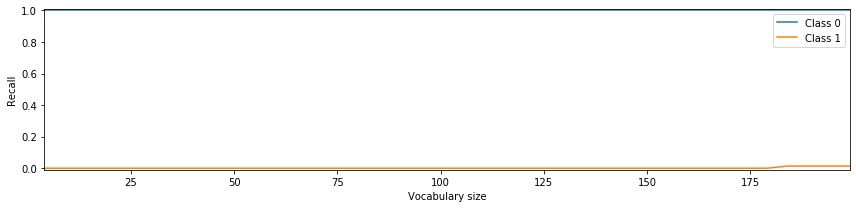

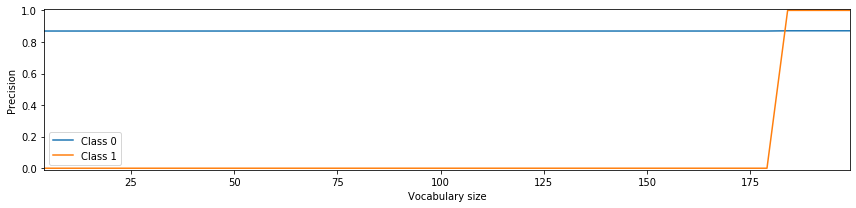

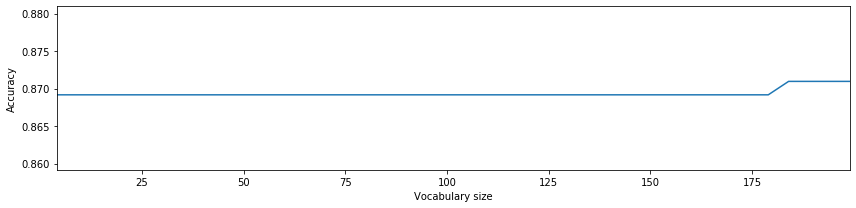

In [196]:
plot_precision_recall(X_train, y_train, y_num_train, X_val, y_num_val, BoW)

### Задание 3 (2 балла)
Теперь добавим в BoW стемминг. Для этого нам понадобится класс SnowballStemmer из пакета `nltk`

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [197]:
class BowStem:
    def __init__(self, X, voc_limit=1000):
        self.X = X.values
        self.voc_limit = voc_limit
        self.bow = self.create_dict()
        
    def create_dict(self):
        c = Counter()
        stemmer = SnowballStemmer('english')
        for i in range(self.X.shape[0]):
            word_list = np.array(re.sub("[^\w]", " ",  self.X[i][0].lower()).split())
            for word in np.unique(word_list):
                word_list = np.where(word_list == word, stemmer.stem(word), word_list)
            counter = Counter(word_list)
            c += counter
        if len(c) > self.voc_limit:
            return OrderedDict(c.most_common(self.voc_limit))
        else:
            return OrderedDict(c.most_common())
        
    def transform(self, X):
        transformed_X = []
        X = X.values
        stemmer = SnowballStemmer('english')
        for i in range(X.shape[0]):
            word_list = np.array(re.sub("[^\w]", " ",  X[i][0].lower()).split())
            for word in np.unique(word_list):
                word_list = np.where(word_list == word, stemmer.stem(word), word_list)
            for word in np.unique(word_list):
                if word in self.bow.keys():
                    word_list = np.where(word_list == word, self.bow[word], word_list)
                else:
                    word_list = np.where(word_list == word, 0, word_list)
            transformed_X.append(word_list.astype(int))
        return np.array(transformed_X)

In [198]:
bows = BowStem(X_train, voc_limit=500)
X_train_bows = bows.transform(X_train)
X_test_bows = bows.transform(X_val)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [199]:
predictor = NaiveBayes(0.001)
y_num_train = [int(y=='spam') for y in y_train]
predictor.fit(X_train_bows, y_train)
y_pred = predictor.predict(X_test_bows)
y_num_val = [int(y=='spam') for y in y_val]
get_precision_recall_accuracy(y_pred, y_num_val)

({0: 0.8691756272401434, 1: 0}, {0: 1.0, 1: 0.0}, 0.8691756272401434)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


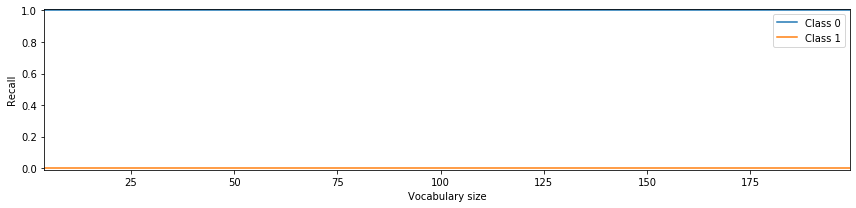

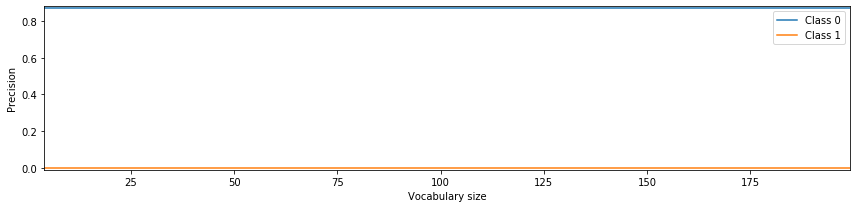

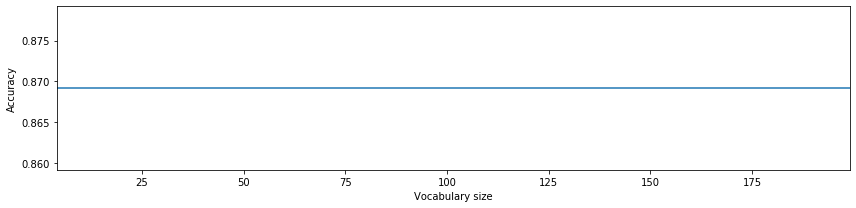

In [200]:
plot_precision_recall(X_train, y_train, y_num_train, X_val, y_num_val, BowStem)